# Transit Least Squares (TLS) Tutorial
In this tutorial, we will demonstrate the usage of the *Transit Least Squares* algorithm for transit detection, which is more sensitive than the Box Least Squares (BLS) method. The transit periodogram computes the log likelihood of the "transit" fit (maximized over transit depth, duration, and phase) for a list of periods. Peaks in the periodogram generally indicate transiting planets or other unmodeled noise.

To demonstrate the code, we start by downloading the K2 light curve for K2-3: A system with [3 known transiting planets](http://iopscience.iop.org/article/10.1088/0004-637X/804/1/10/meta). This tutorial draws heavily from Dan Foreman-Mackey's excellent [BLS tutorial](https://gist.github.com/dfm/96e30d891c0d351daae9aaaef56d3e78).

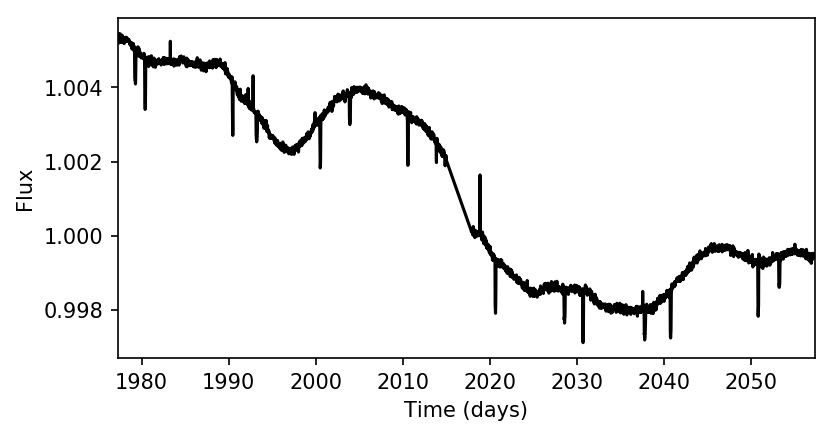

In [1]:
import numpy
import scipy
import matplotlib.pyplot as plt
from astropy.io import fits
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

url = "https://archive.stsci.edu/hlsps/everest/v2/c01/201300000/67065/"\
    "hlsp_everest_k2_llc_201367065-c01_kepler_v2.0_lc.fits"
with fits.open(url) as hdus:
    data = hdus[1].data
    t = data["TIME"]
    y = data["FLUX"]
    q = data["QUALITY"]

# This is from the EVEREST source. These are the flagged data points
# that should be removed. Ref: https://github.com/rodluger/everest
m = numpy.isfinite(t) & numpy.isfinite(y)
for b in [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17]:
    m &= (q & (2 ** (b - 1))) == 0

t = numpy.ascontiguousarray(t[m], dtype=numpy.float64)
y = numpy.ascontiguousarray(y[m], dtype=numpy.float64)
y = y / numpy.median(y)

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 3))
ax.plot(t, y, "k")
ax.set_xlim(t.min(), t.max())
ax.set_xlabel("Time (days)")
ax.set_ylabel("Flux");

We remove long-term trends with a running-window median filter:

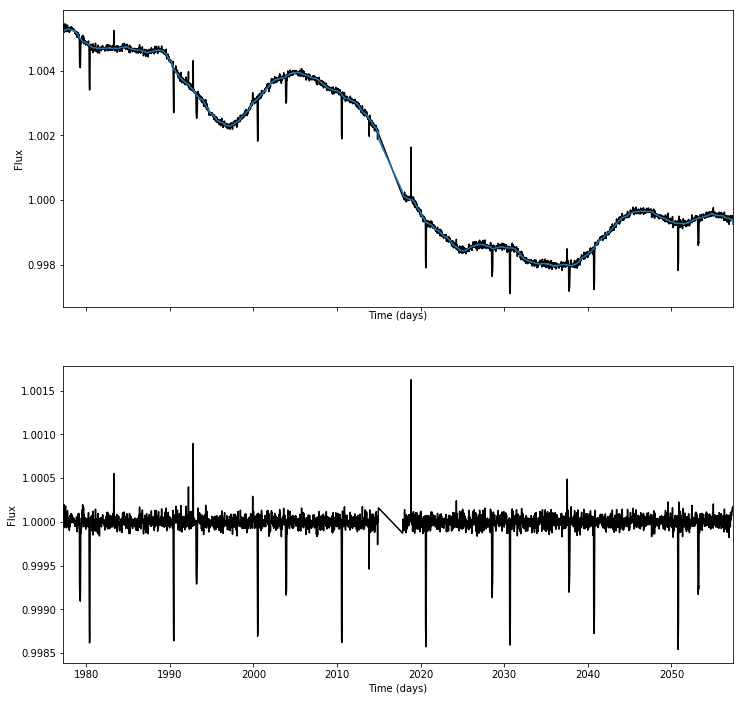

In [2]:
from scipy.signal import medfilt
trend = medfilt(y, 45)
y_filt = y - trend + 1
dy = numpy.full(numpy.size(y_filt), 1)

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 12))
ax = axes[0]
ax.plot(t, y, "k")
ax.plot(t, trend)
ax.set_xlabel("Time (days)")
ax.set_ylabel("Flux")

ax = axes[1]
ax.plot(t, y_filt, "k")
ax.set_xlim(t.min(), t.max())
ax.set_xlabel("Time (days)")
ax.set_ylabel("Flux");

To find a transiting planet in this light curve, we use the TransitLeastSquares class. Its interface follows the [BLS reference implementation](http://dfm.io/astropy/stats/bls.html#objectives) in Astropy by Dan Foreman-Mackey.

While we also have an *autopower* function in preparation, we here show the *power* call which allows the user to define a search grid of periods, durations, and transit depths, as well as limb darkening and impact parameter:

In [3]:
from TransitLeastSquares import TransitLeastSquares, period_grid, fold
periods = period_grid(
    R_star=1,  # in units of solar radii
    M_star=1,  # in units of solar masses
    time_span=max(t) - min(t),
    period_min=0,  # in units of days
    period_max=99,
    oversampling_factor=5)

# Define grids of transit depths and widths
depths = numpy.geomspace(50*10**-6, 0.01, 75)
durations = numpy.geomspace(1.01/numpy.size(t), 0.02, 50)

Now we can run the actual search. This takes several minutes on my machine. For quick tests, set ```period_min=9.9``` and ```period_max=10.2```

In [4]:
model = TransitLeastSquares(t, y_filt, dy)
results = model.power(periods, durations, depths, limb_darkening=0.5)

 24%|██▍       | 905/3750 [00:00<00:00, 9043.67it/s]

Creating model cache: 50 durations x 75 depths = 3750 curves


100%|██████████| 3750/3750 [00:00<00:00, 9261.22it/s]

Searching 3632 data points, 14174 periods from 0.602 to 40.036 days, using all 8 CPU threads



  9%|▉         | 337/3632 [00:00<00:00, 3369.78it/s]

Finding best T0 for period 10.05556


100%|██████████| 3632/3632 [00:00<00:00, 9326.98it/s]


We can print some key results (more stats to come soon)

In [9]:
print('Period', format(results.best_period, '.5f'), 'd')
print(len(results.transit_times), 'transit times in time series:', \
        ['{0:0.5f}'.format(i) for i in results.transit_times])
print('Transit depth', format(results.best_depth, '.5f'))
print('Best duration (fractional period)', format(results.best_duration, '.5f'))
print('Best duration (days)', format(results.transit_duration_in_days, '.5f'))
print('Signal detection efficiency (SDE):', results.SDE)

Period 10.05556 d
8 transit times in time series: ['1980.41676', '1990.47232', '2000.52788', '2010.58345', '2020.63901', '2030.69458', '2040.75014', '2050.80570']
Transit depth 0.00135
Best duration (fractional period) 0.01185
Best duration (days) 0.11859
Signal detection efficiency (SDE): 47.572390058069615


Now we plot the test statistic:

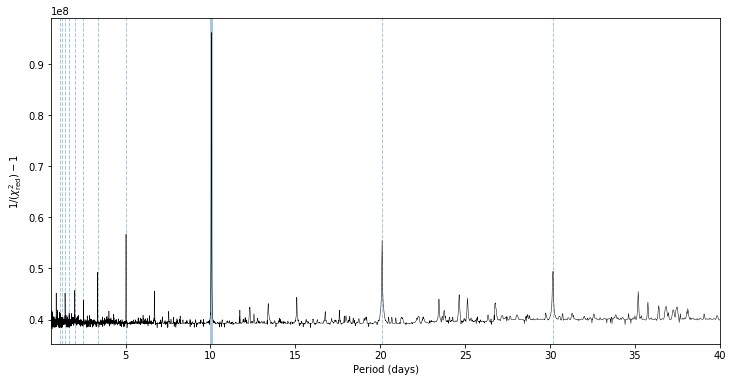

In [6]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12, 6))
ax = plt.gca()
ax.axvline(results.best_period, alpha=0.4, lw=3)
plt.xlim(numpy.min(periods), numpy.max(periods))
for n in range(2, 10):
    ax.axvline(n*results.best_period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results.best_period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.plot(results.periods, 1/results.power - 1, color='black', lw=0.5)
plt.ylabel(r'$1 / (\chi^2_{\rm red}) - 1$')
plt.xlabel('Period (days)');

OK, so the highlighted peak at P=10.05 days corresponds to the best period, and some (sub) harmonics are visible and marked with dotted lines. Let's make a plot phase-folded to the best period and overplot the model.

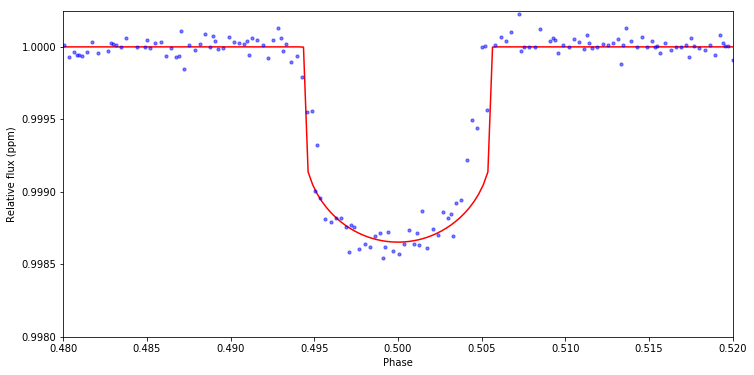

In [7]:
phases = fold(t, results.best_period, T0=results.best_T0+ results.best_period/2)
sort_index = numpy.argsort(phases)
phases = phases[sort_index]
flux = y_filt[sort_index]
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12, 6))
plt.scatter(phases, flux, color='blue', s=10, alpha=0.5, zorder=2)
plt.plot(numpy.linspace(0, 1, numpy.size(results.folded_model)), 
    results.folded_model, color='red', zorder=1)
plt.ylim(0.998, 1.00025)
plt.xlim(0.48, 0.52)
plt.xlabel('Phase')
plt.ylabel('Relative flux (ppm)');

We can also make a plot for the whole time series. It is not a pixel-perfect representation of the actual model, but useful to identify the individual transits. We plot the in-transit data points in red, other data points in blue, and the model in red.

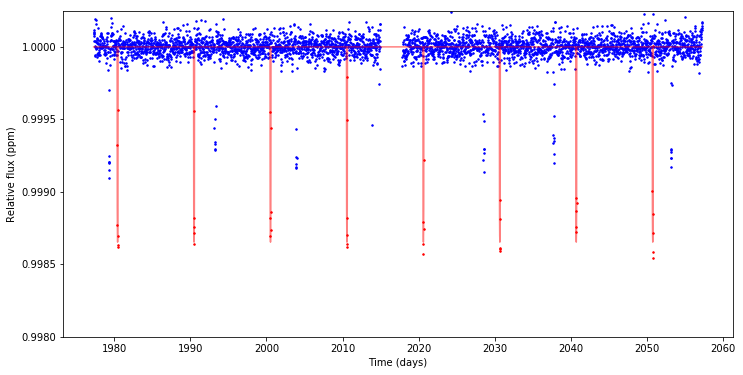

In [8]:
in_transit = model.transit_mask(
    t,
    results.best_period,
    results.transit_duration_in_days,
    results.best_T0)
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12, 6))
plt.plot(t[in_transit], y_filt[in_transit], '.r', ms=3, zorder=0)
plt.plot(t[~in_transit], y_filt[~in_transit], '.b', ms=3, zorder=0)
plt.plot(numpy.linspace(min(t), max(t), numpy.size(results.model_flux)), 
    results.model_flux, alpha=0.5, color='red', zorder=1)
plt.ylim(0.998, 1.00025)
plt.xlabel('Time (days)')
plt.ylabel('Relative flux (ppm)');

That's all for now! There are two more planets to be found in this system (to be continued)...